In [3]:
import numpy as np
import pandas as pd

import skimage.io

import matplotlib.pyplot as plt

import os

# from tqdm import tqdm_notebook

In [ ]:
tr = pd.read_csv('../train.csv')

In [ ]:
tr.head(5)

In [10]:
tr.shape

(25361, 2)

In [11]:
tr['Image'].unique().shape

(25361,)

In [12]:
tr['Id'].unique().shape

(5005,)

Wow so this is quite imbalanced. I wonder if Siamese networks and doing comparisons is the best way?

In [13]:
whalects = pd.DataFrame(tr['Id'].value_counts(), columns=['WhaleID', 'Cts'])

In [14]:
trfiles = os.listdir('../train/')

In [15]:
len(trfiles)

25361

In [16]:
im1 = skimage.io.imread('../train/'+trfiles[0])
im2 = skimage.io.imread('../train/'+trfiles[1])

In [17]:
im1.shape

(563, 1049)

In [18]:
im2.shape

(590, 1050, 3)

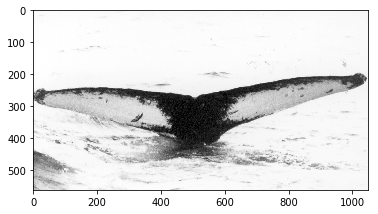

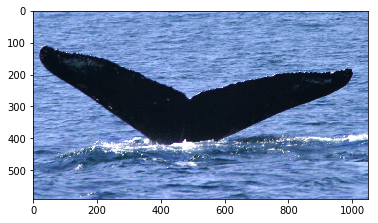

In [19]:
plt.imshow(im1, cmap='gray'); plt.show()
plt.imshow(im2)

So the images are all of different dimension, and we will need to figure out how many are color, the channels, etc. Let's load them in and see.

In [20]:
img_dim = [skimage.io.imread('../train/' + x).shape for x in tqdm_notebook(tr['Image'].values)]

In [21]:
def norm_dims(x):
    if len(x)==2:
        y = (x[0], x[1], 1)
    else:
        y = x
    return y
dims = pd.DataFrame([norm_dims(x) for x in tqdm_notebook(img_dim)], columns=['x', 'y', 'channels'])

In [22]:
tr.shape, dims.shape

((25361, 2), (25361, 3))

In [23]:
tre = pd.concat([tr, dims], axis=1)

In [24]:
tre.shape

(25361, 5)

In [25]:
tre['channels'].value_counts()

3    21975
1     3386
Name: channels, dtype: int64

In [26]:
tre.to_csv('image_dims.csv', index=False)

In [30]:
tre['Id'].value_counts()[:10]

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
w_700ebb4      57
w_3de579a      54
w_564a34b      51
w_fd3e556      50
w_88e4537      49
Name: Id, dtype: int64

In [31]:
tre['Id'].value_counts()[-10:]

w_c06798f    1
w_9340ca3    1
w_b3cf11e    1
w_e79fed4    1
w_82fac51    1
w_71f5c74    1
w_fe8e55c    1
w_428f3c0    1
w_6b51160    1
w_510f3ee    1
Name: Id, dtype: int64

In [37]:
tre['Id'].value_counts().value_counts().sort_index()

1       2073
2       1285
3        568
4        273
5        172
6        136
7         86
8         76
9         62
10        46
11        39
12        26
13        14
14        16
15        19
16        16
17        17
18         6
19         8
20         7
21         7
22         5
23         4
24         7
25         2
27         1
29         2
30         3
31         3
32         1
33         1
34         2
35         1
36         1
37         3
40         3
45         2
47         1
48         1
49         1
50         1
51         1
54         1
57         1
61         1
62         1
65         1
73         1
9664       1
Name: Id, dtype: int64

Let's see how many non-singleton images there are

In [40]:
tre['Id'].value_counts().value_counts().sort_index()[1:-1].sum()

2931

And let's see how many pairs of possible images there would be, it may be easiest just to make all those and draw randomly (or train on every pair every time) and then randomly draw from all possible singleton pairs.

In [47]:
coi = tre['Id'].value_counts().value_counts().sort_index()[1:-1]
(coi.index.values**2 * coi.values).sum()

153498

In [49]:
(9664 + 2073)**2, 2073**2

(137757169, 4297329)

In [ ]:
1l

We don't necessarily know when the new whales doesn't contain duplicates... HMMMMMM. We should have enough random pairs to draw from.

Should we generate a pre-list, or should we generate a new list for each batch, or each epoch?

Let's trim down to only 3 channel (where we know transfer learning wont have any issues) and to the top 20 classes, and then do a multiclass classification, just to see how well it does on this more simple task. It will also give a chance to practice some of the learning rate technique finders.

In [48]:
whalects = pd.DataFrame(tr['Id'].value_counts()).reset_index()
whalects.columns = ['WhaleID', 'Cts']

In [53]:
whalesub = whalects[1:21]
whalesub = pd.merge(whalesub, tr, how='inner', left_on='WhaleID', right_on='Id')

In [56]:
whalesub = whalesub[['Image','Id']]
whalesub.columns = ['image_name', 'tags']

In [58]:
whalesub.to_csv('whale_sub_labels.csv', index=False)

In [3]:
tst = pd.read_csv('whale_sub_labels.csv')

In [4]:
tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 2 columns):
image_name    974 non-null object
tags          974 non-null object
dtypes: object(2)
memory usage: 15.3+ KB


In [5]:
tst['tags'].unique().shape

(20,)

In [64]:
from shutil import copyfile

In [65]:
for fname in whalesub['image_name'].values:
    copyfile('../train/' + fname, '../train_subset/' + fname)

### Channel/size exploration

In [4]:
chan = pd.read_csv('../exploratory_analysis/image_dims.csv')

In [5]:
chan.head()

,Image,Id,x,y,channels
0,0000e88ab.jpg,w_f48451c,700,1050,3
1,0001f9222.jpg,w_c3d896a,325,758,3
2,00029d126.jpg,w_20df2c5,497,1050,3
3,00050a15a.jpg,new_whale,525,1050,3
4,0005c1ef8.jpg,new_whale,525,1050,3


In [6]:
chan[chan['channels']==3].shape

(21975, 5)

In [7]:
chan[chan['channels']==1].shape

(3386, 5)